In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'

Initialization done, Notebook was last run on: 25/06/2019


In [2]:
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']

import hax
hax.init(experiment='XENON1T',
         pax_version_policy = '6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = [#'/home/gvolta/minitrees_test'
                           '/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/project/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'
                          ],
         make_minitrees = True)

In [3]:
dali_path = '/dali/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'
project_path = '/project/lgrandi/giovo/pickle_haxcache/pax_v6.10.1/'

### Opening data

In [4]:
file = project_path +  'data_cut_SR1_S1PL.pkl'
data = pd.read_pickle(file)

In [5]:
data_white = data.copy()
data = data[data['s1'] < 2e4]

## Data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


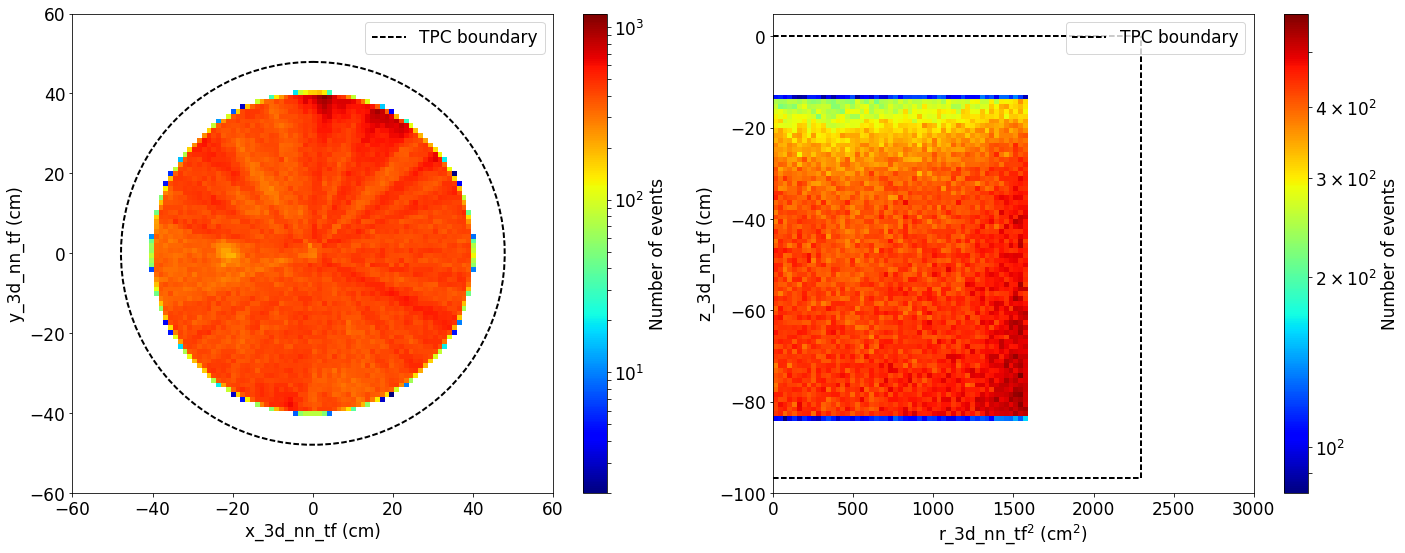

In [6]:
data_distribution(data_white, 'x_3d_nn_tf', 'y_3d_nn_tf', 'z_3d_nn_tf', 'r_3d_nn_tf', bins=[100,100])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


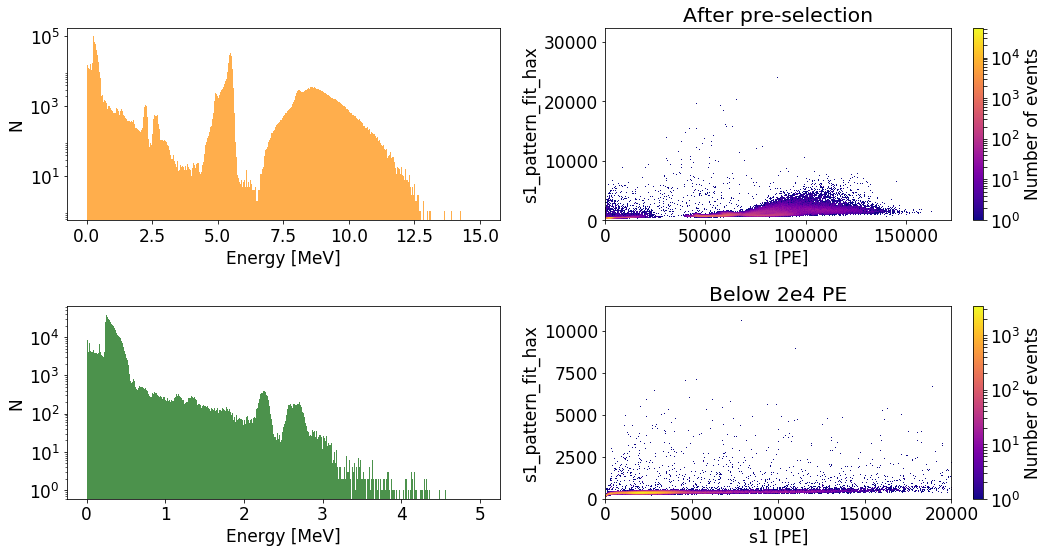

In [7]:
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.hist(data_white['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(222)
plt.hist2d(data_white['s1'], data_white['s1_pattern_fit_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('After pre-selection')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(223)
plt.hist(data['CES']/10**6, bins = (700), 
         range=(0, 5), 
         histtype='bar', color='darkgreen',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

plt.subplot(224)
plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 400), 
           #range=((0,2e4), (0,5e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.title('Below 2e4 PE')
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')


plt.tight_layout()
plt.show()

### Cut definition 

In [8]:
def S1PatternLikelihoodProfile(x, a, b, c, d, e):
    return a + b*pow(x, 0.5) + c*x + d*pow(x, 1.5) + e*pow(x, 2)

a = -17.384885
b = 24.894875
c = 2.794984
d = -0.237268
e = 0.005549
init_old = [a, b, c, d, e]

In [9]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5  

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def fit_func(x, p0, p1, p2, p3, p4, p5, p6, p7):
    return poly5(x, p0, p1, p2, p3, p4, p5) + inv_poly(x, p6, p7)

The definition of the cut has been divided into two region: at low-energy has been used the same fucntion of SR1, for the other values a new function has been used in order to follow better the data distribution. The parameter space has been divided in equally spaced slice of $s1$ and, as input for cut profile fitting, the $\mu+3\sigma$ of the normal distribution for each slices has been used.

In [56]:
hist, xbins, ybins = np.histogram2d(data['s1'], data['s1_pattern_fit_hax'], bins = (4000, 200), 
                                   range=((0,2e4), (0,4500)))
ybins_center = [0.5*(ybins[i]+ybins[i+1]) for i in range(len(ybins)-1)]
xbins_center = [0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)]

perc = np.empty(len(xbins_center))
for i in tqdm(range(len(hist))):
    perc[i] = percentile(index = i, hist=hist, ybins=ybins, xbins=xbins, q=0.99, var1='s1', var2='s1 patter fit hax')
    
xbins_center_valid, perc_valid = dropNaNforFit(xbins_center, perc)
xbins_center_valid, perc_valid = dropNegforFit(xbins_center_valid, perc_valid)

# perc_valid -> 99% s1 pattern fit in s1 slice
# xbins_center_valid -> correspondent s1 to 99% s1 pattern fit

 73%|███████▎  | 2909/4000 [05:00<01:52,  9.69it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
 75%|███████▌  | 3011/4000 [05:08<01:41,  9.76it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 4000/4000 [06:43<00:00,  9.92it/s]


In [65]:
init = [ 4.78681704e+02,  1.40005246e-02, -7.12468987e-06,  2.23409109e-09,
         -2.23585862e-13,  7.15271136e-18, -2.14589222e+03,  3.16923133e+03]

popt, pcov = curve_fit(fit_func, xbins_center_valid[60:], perc_valid[60:], p0=init)
print(init, '\n\n', popt, '\n\n', pcov)

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 7.15271136e-18, -2145.89222, 3169.23133] 

 [  5.16997628e+02  -1.88882596e-03   1.91191215e-06  -2.12021514e-10
   4.59846315e-15   1.58173625e-19  -3.31008908e+03   2.40983105e+04] 

 [[  1.17001918e+05  -2.71679073e+01   4.42063197e-03  -3.84113561e-07
    1.64196741e-11  -2.71314737e-16  -4.45636440e+06   4.64819066e+07]
 [ -2.71679073e+01   6.54828805e-03  -1.09642979e-06   9.72882955e-11
   -4.22421074e-15   7.06387032e-20   1.01451098e+03  -1.03982206e+04]
 [  4.42063197e-03  -1.09642979e-06   1.88136638e-10  -1.70189260e-14
    7.50182289e-19  -1.26955727e-23  -1.62830202e-01   1.64961566e+00]
 [ -3.84113561e-07   9.72882955e-11  -1.70189260e-14   1.56446550e-18
   -6.98685449e-23   1.19511673e-27   1.40145384e-05  -1.40858795e-04]
 [  1.64196741e-11  -4.22421074e-15   7.50182289e-19  -6.98685449e-23
    3.15484423e-27  -5.44649140e-32  -5.94985617e-10   5.94645849e-09]
 [ -2.71314737e-16   7.06387032e

In [66]:
popt_oldV, pcov_oldV = curve_fit(S1PatternLikelihoodProfile, xbins_center_valid[:60], perc_valid[:60], p0=init_old)
print(init, '\n\n', popt_oldV ,'\n\n', pcov_oldV)

[478.681704, 0.0140005246, -7.12468987e-06, 2.23409109e-09, -2.23585862e-13, 7.15271136e-18, -2145.89222, 3169.23133] 

 [  1.59947241e+01   1.70047019e+01   3.04440953e+00  -2.53926414e-01
   5.47698785e-03] 

 [[  6.05860013e+01  -3.27637625e+01   5.68490951e+00  -3.94268014e-01
    9.49095961e-03]
 [ -3.27637625e+01   1.93336406e+01  -3.52219672e+00   2.52014245e-01
   -6.19956827e-03]
 [  5.68490951e+00  -3.52219672e+00   6.62850273e-01  -4.85314130e-02
    1.21449878e-03]
 [ -3.94268014e-01   2.52014245e-01  -4.85314130e-02   3.61572482e-03
   -9.17198497e-05]
 [  9.49095961e-03  -6.19956827e-03   1.21449878e-03  -9.17198497e-05
    2.35223854e-06]]


In [67]:
x = np.linspace(0, 2e4, 1e4)

y_shingo = S1PatternLikelihoodProfile(x, *init_old) # s1 patter fit from Shingo cut definition 
y = fit_func(x, *popt) # s1 patter fit from new cut definition fit
y_oldV = S1PatternLikelihoodProfile(x, *popt_oldV) # s1 patter fit from old cut definition fit

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


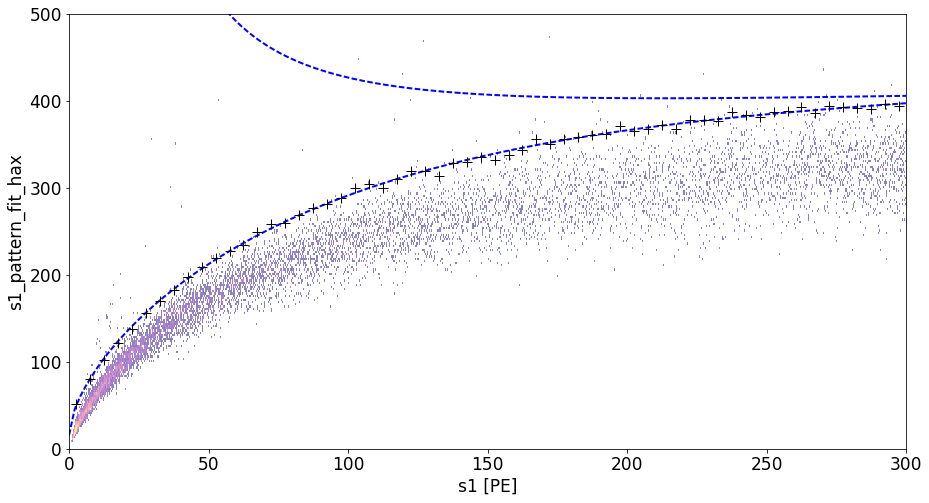

In [68]:
plt.figure(figsize=(15,8))

plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (4000, 200), 
           range=((0,300), (0,500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.5)
plt.plot(x, y, 'b--', lw=2)
plt.plot(x, y_oldV, 'b--', lw=2)
plt.plot(xbins_center_valid, perc_valid, 'k+', ms = 10)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add


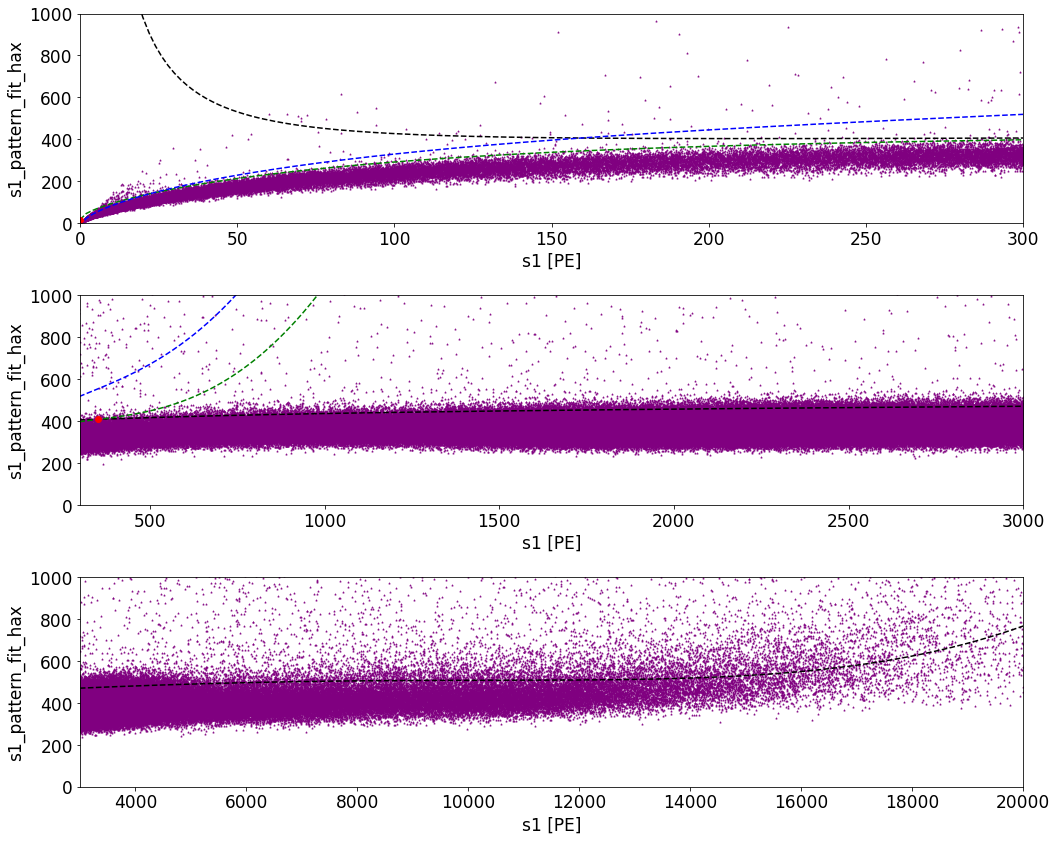

[   0.          352.03520352] [  15.99472406  408.33456575]


In [73]:
plt.figure(figsize=(15,12))

plt.subplot(311)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
plt.plot(x, fit_func(x, *popt), 'k--', label = 'New fitted cut')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--',label = 'Old fitted cut')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--', label = 'SR1 cut')
idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile(x, *popt_oldV) - fit_func(x, *popt)))).flatten()
plt.plot(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV), 'ro')
plt.xlim(0,300)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(312)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
idx = np.argwhere(np.diff(np.sign(S1PatternLikelihoodProfile(x, *popt_oldV) - fit_func(x, *popt)))).flatten()
plt.plot(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV), 'ro')
plt.xlim(300,3000)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.subplot(313)
plt.scatter(data['s1'], data['s1_pattern_fit_hax'], s=1, marker='^', c='purple')
#plt.plot(data['s1'], cut(data['s1'], 45, popt), 'ko', ms=1)
plt.plot(x, fit_func(x, *popt), 'k--')
plt.plot(x, S1PatternLikelihoodProfile(x, *popt_oldV), 'g--')
plt.plot(x, S1PatternLikelihoodProfile(x, *init_old), 'b--')
plt.xlim(3000,2e4)
plt.ylim(0,1000)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()
plt.show()

print(x[idx], S1PatternLikelihoodProfile(x[idx], *popt_oldV))

### Cut

In [74]:
data_cut = data.copy()
data_cut['CutS1PF'] = (((data_cut['s1_pattern_fit_hax'] < S1PatternLikelihoodProfile(data_cut['s1'], *popt_oldV))*(data_cut['s1']<x[idx][1]))
                      +((data_cut['s1_pattern_fit_hax'] < fit_func(data_cut['s1'], *popt))*(data_cut['s1']>=x[idx][1])))
data_cut = hax.cuts.selection(data_cut, data_cut['CutS1PF'] == True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Unnamed selection: 24336 rows removed (97.25% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


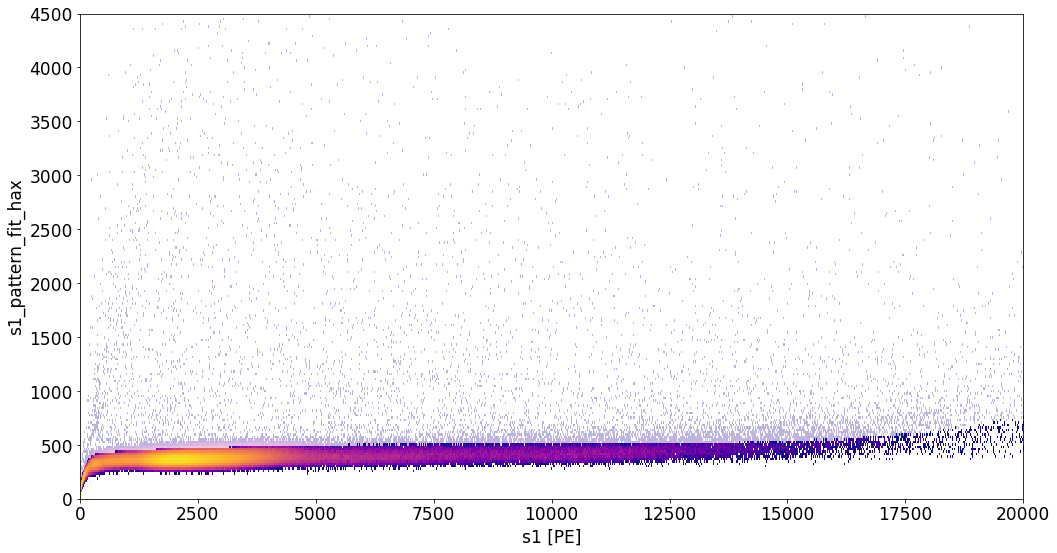

In [99]:
plt.figure(figsize=(15,8))
hist, xbins, ybins, _ = plt.hist2d(data['s1'], data['s1_pattern_fit_hax'], bins = (1000, 200), 
           range=((0,2e4), (0,4500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 0.3)
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(data_cut['s1'], data_cut['s1_pattern_fit_hax'], bins = (1000, 200), 
           range=((0,2e4), (0,4500)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(), 
           cmin = 1,alpha = 1)
plt.xlabel('s1 [PE]')
plt.ylabel('s1_pattern_fit_hax')

plt.tight_layout()
plt.show()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [100]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
    acceptance.append(hist_cut[i].sum()/hist[i].sum())
    sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))
    
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance_nan = acceptance[np.logical_not(np.isnan(acceptance))]
sigma_nan = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance_nan)
acceptance_median = np.median(acceptance_nan)

print(acceptance_mean, acceptance_median)

0.745152115004 0.8375


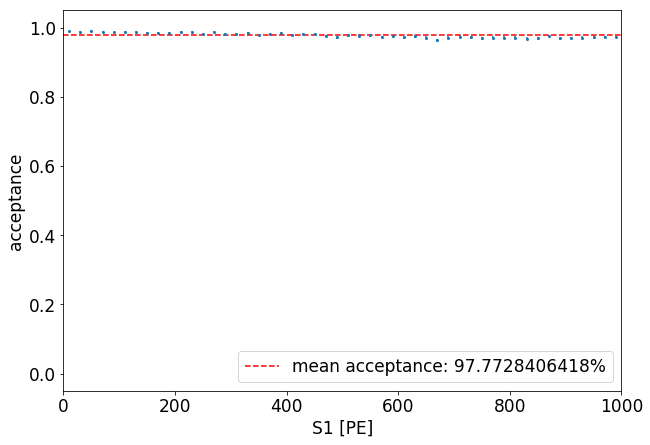

In [101]:
acceptance_mean = np.mean(acceptance_nan[:50])
acceptance_median = np.median(acceptance_nan[:50])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=1e3, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 1000)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

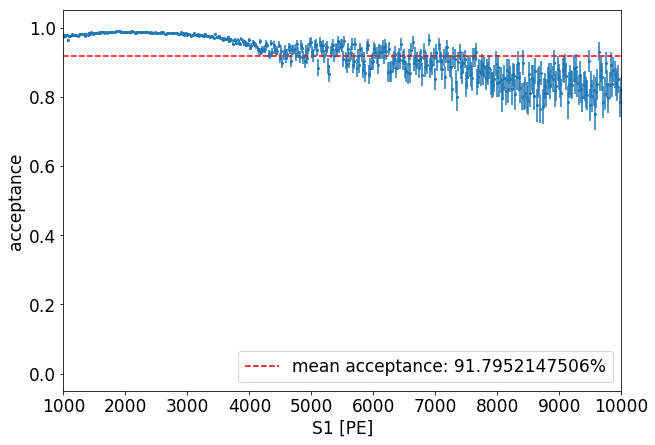

In [102]:
acceptance_mean = np.mean(acceptance_nan[50:500])
acceptance_median = np.median(acceptance_nan[50:500])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e3, xmax=1e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e3, 1e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

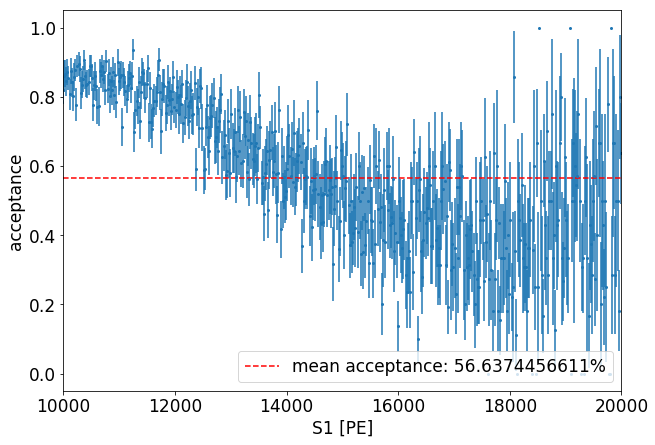

In [103]:
acceptance_mean = np.mean(acceptance_nan[500:])
acceptance_median = np.median(acceptance_nan[500:])

plt.figure(figsize=(10,7))

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=1e4, xmax=2e4, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(1e4, 2e4)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

## Check between [0;15e3]

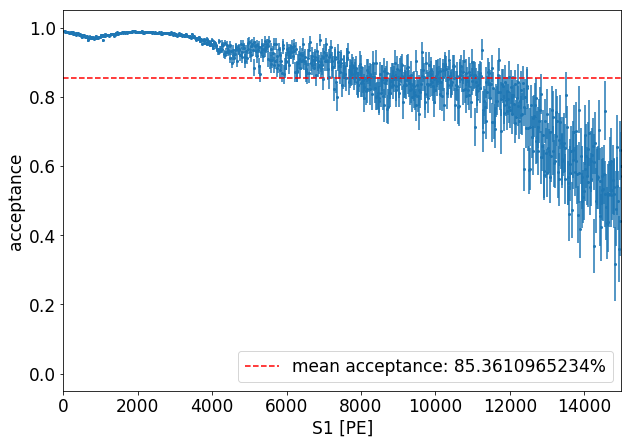

In [104]:
plt.figure(figsize=(10,7))

acceptance_mean = np.mean(acceptance_nan[:750])
acceptance_median = np.median(acceptance_nan[:750])

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=acceptance_mean, xmin=0, xmax=15e3, linestyle = '--', 
           label='mean acceptance: ' + str(100*acceptance_mean) + '%', color = 'red')
plt.legend(loc='lower right')
plt.xlim(0, 15e3)
plt.xlabel('S1 [PE]')
plt.ylabel('acceptance')

In [105]:
tmp = data[data['s1'] > 15e3]
tmp2 = data_cut[data_cut['s1'] > 15e3]

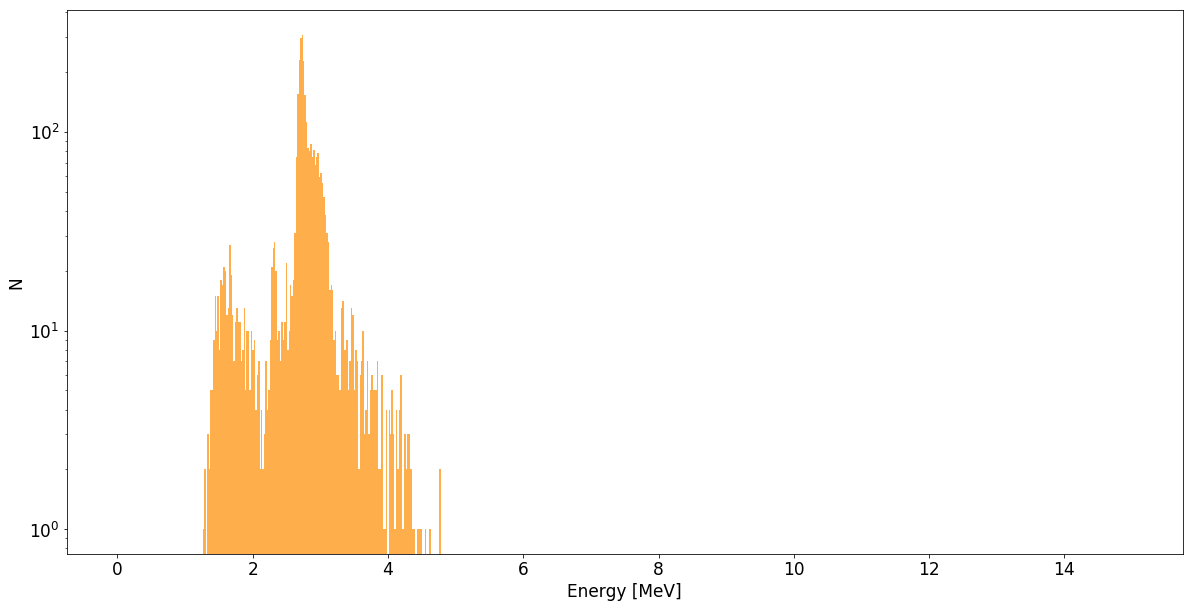

In [106]:
plt.hist(tmp['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')

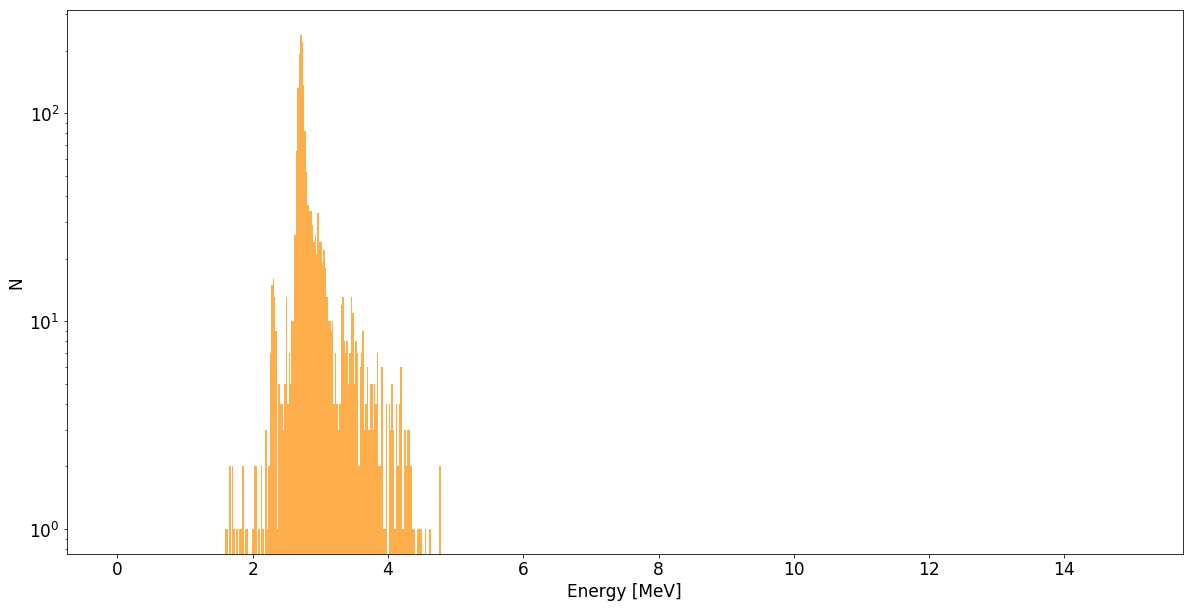

In [55]:
plt.hist(tmp2['CES']/10**6, bins = (700), 
         range=(0, 15), 
         histtype='bar', color='darkorange',
         alpha = 0.7)
plt.xlabel('Energy [MeV]')
plt.ylabel('N')
plt.yscale('log')